# MC on the extracted prior to compare to the posterior

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
import tqdm

import matplotlib.ticker as mpl_ticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline
import matplotlib.patches as mpatches
import matplotlib.transforms as mpl_transforms
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

from llm_elicited_priors.plotting import graph_theme
from llm_elicited_priors.metrics import  e_coefficient
from llm_elicited_priors.utils import cut_end_points

In [2]:
width = 7.1413/0.75
colwidth = 3.433071
linewidth = 7.12598

In [8]:
CHAIN_PATH = "./posteriors/mc_on_internal_model_prior"
POSTERIOR_PATH = "./posteriors/internal_model/posterior_with_multiple_messages"
SAVE_PATH = "./results/"

DATASETS = [
    d 
    for d in os.listdir(CHAIN_PATH) 
    if os.path.isdir(os.path.join(CHAIN_PATH, d))
]

DATASET_MODEL_TYPES = {
    "fake_data": "regression",
    "breast_cancer": "classification",
    "uti": "classification",
    "california_housing": "regression",
    "heart_disease": "classification",
    "wine_quality": "classification",
    "diabetes": "regression",
    "hypothyroid": "classification",
}

In [9]:
DATASETS

['fake_data',
 'hypothyroid',
 'heart_disease',
 'diabetes',
 'breast_cancer',
 'wine_quality',
 'california_housing']

In [10]:
chains = {
    dataset: [
        np.load(
            Path(CHAIN_PATH, dataset, f)
        )
        for f in os.listdir(Path(CHAIN_PATH, dataset))
    ]
    for dataset in DATASETS
}

In [11]:
approximated_posteriors = {}
for dataset in DATASETS:
    approx_posteriors_for_datset = json.load(
        open(
            Path(POSTERIOR_PATH, dataset, "posterior_parameter_samples.json"),
            "r"
        )
    )

    approximated_posteriors[dataset] = []
    for a in approx_posteriors_for_datset:
        approximated_posteriors_repeat = []
        for b in a:
            for c in b:
                if c is not None:
                    approximated_posteriors_repeat.append(c)
        
        approximated_posteriors[dataset].append(
            np.array(approximated_posteriors_repeat)
        )

In [12]:
difference_test_values = {}

for dataset in tqdm.tqdm(DATASETS, desc="Calculating e-statistic values"):
    difference_test_values[dataset] = []
    for split_number, (single_chain, single_approximated_posterior) in enumerate(
        zip(
            chains[dataset], approximated_posteriors[dataset]
        )
    ):

        if DATASET_MODEL_TYPES[dataset] == "regression":
            single_chain = single_chain[:, :, 1:] # removing the y noise
        n_features = single_chain.shape[-1] - 1

        flat_single_chain = single_chain.reshape(-1, single_chain.shape[-1])
        ## energy distance
        difference_test_values[dataset].append([
            e_coefficient(
                single_approximated_posterior[:, 1:], 
                flat_single_chain[:, 1:][
                    np.random.choice(
                        a=flat_single_chain.shape[0], 
                        size=100000, 
                        replace=False,
                    )
                ], 
                chunk_size=1000
            ).item()
        ] * n_features)

Calculating e-statistic values: 100%|██████████| 7/7 [06:29<00:00, 55.66s/it]


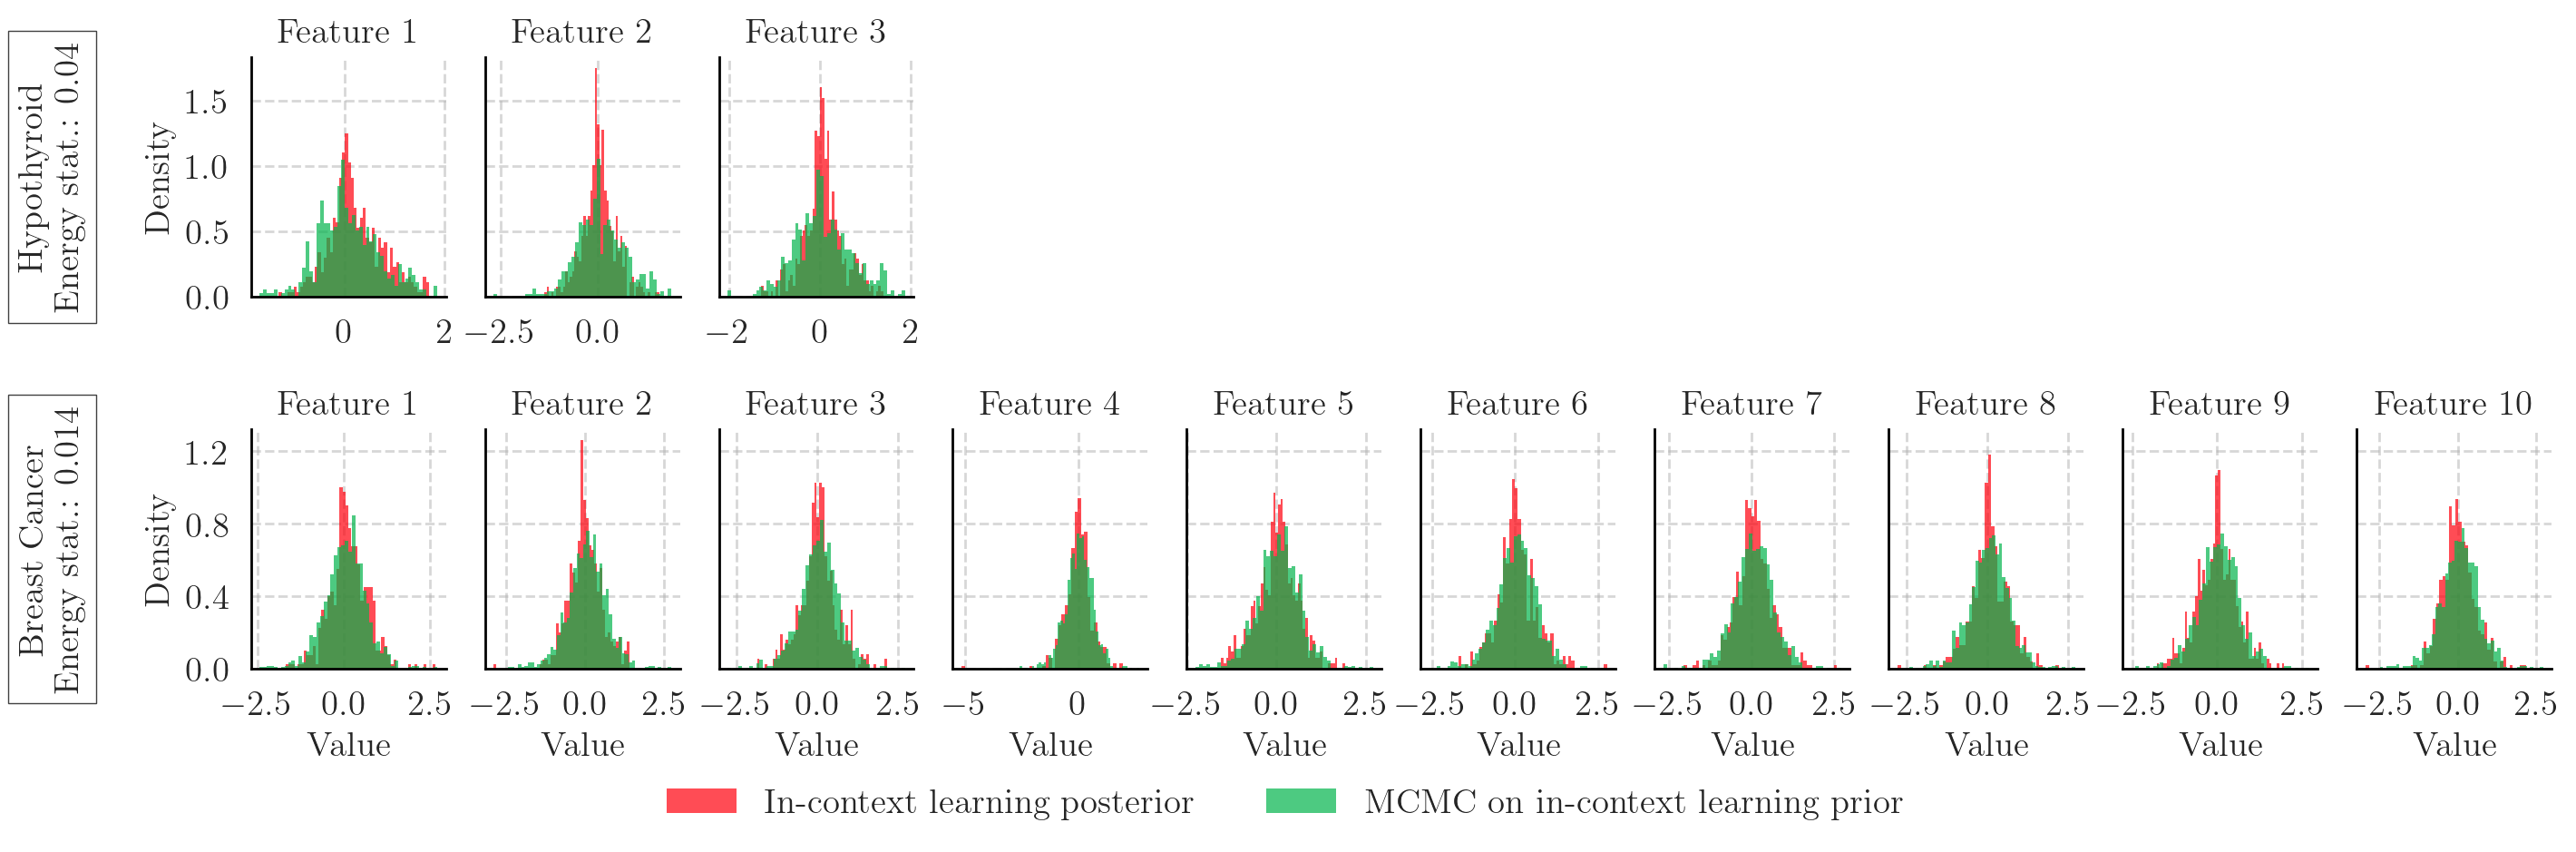

In [13]:
plt.close()

split_to_plot = 0

alpha = 0.7

hist_config = dict(
    alpha = alpha,
    bins=50,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)


dataset_order = [
    #"heart_disease",
    "hypothyroid",
    #"diabetes",
    "breast_cancer",
    #"california_housing",
    #"wine_quality",
]

dataset_nice_names = {
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "wine_quality": "Wine Quality",
    "heart_disease": "Heart Disease",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

palette = {
    "internal_model": "xkcd:bright red",
    "mc_prior":  "xkcd:shamrock",
}

fontsize = 14

with graph_theme():

    ncols = 10
    nrows = len(dataset_order)
    fig_width = 2*linewidth
    fig_height = 0.6*0.8*2*1.1*linewidth/1.618

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(fig_width, fig_height),
        sharey="row",
    )

    for d_i, dataset in enumerate(dataset_order):
        for split_number, (single_chain, single_approximated_posterior) in enumerate(
            zip(
                chains[dataset], approximated_posteriors[dataset]
            )
        ):
            
            if split_number != split_to_plot:
                continue
            
            if DATASET_MODEL_TYPES[dataset] == "regression":
                single_chain = single_chain[:, :, 1:] # removing the y noise

            n_features = single_chain.shape[-1] - 1

            flat_single_chain = single_chain.reshape(-1, single_chain.shape[-1])

            for feature in range(n_features):

                ax = axes[d_i, feature]

                sns.histplot(
                    cut_end_points(single_approximated_posterior[:, feature+1], 0, 100),
                    color=palette["internal_model"],
                    ax=ax,
                    **hist_config,
                )

                ax = sns.histplot(
                    cut_end_points(single_chain[:, feature+1, :].ravel(), 0, 100),
                    color=palette["mc_prior"],
                    ax=ax,
                    **hist_config,
                )

                locator = mpl_ticker.MaxNLocator(
                    nbins=4, steps=[1, 2, 4, 5], min_n_ticks=4
                )
                ax.yaxis.set_major_locator(locator)

                ax.set_title(f"Feature {feature+1}", fontsize=fontsize)
                
                ax.tick_params(axis='both', which='major', labelsize=fontsize)

                if feature == 0:
                    ax.set_ylabel("Density", fontsize=fontsize)
                else:
                    plt.setp(ax.get_yticklabels(), visible=False)
                
                if d_i == nrows - 1:
                    ax.set_xlabel("Value", fontsize=fontsize)
                else:
                    ax.set_xlabel("") 

                if dataset == "diabetes":
                    ax.set_xlim(-1, 1)


                if feature == 0:
                    trans = mpl_transforms.blended_transform_factory(
                        fig.transFigure, ax.transAxes
                    )
                    fig.text(
                        0.01, 0.5,
                        f"{dataset_nice_names[dataset]}"
                        + f"\nEnergy stat.: {difference_test_values[dataset][0][0]:.2g}",
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=trans,
                        fontsize=fontsize,
                        rotation=90,
                        multialignment="center",
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.75, 
                            edgecolor='black',
                            linewidth=0.5
                        ),
                    )

                if n_features < ncols:
                    if feature == n_features - 1:
                        for unused_ax in axes[d_i, feature:]:
                            unused_ax.remove()


    fig.legend(
        handles=[
            mpatches.Patch(
                facecolor=palette["internal_model"], alpha=alpha, 
                linewidth=0.0, edgecolor="black",
                label="In-context learning posterior"
            ),
            mpatches.Patch(
                facecolor=palette["mc_prior"], alpha=alpha, 
                linewidth=0.0, edgecolor="black",
                label="MCMC on in-context learning prior"
            ),
        ],
        loc="center",
        ncol=2,
        fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.04),
        frameon=False,
        )

    fig.subplots_adjust(
        hspace=0.55, wspace=0.2,
        left=0.1, right=0.99,
        top=0.925, bottom=0.2
    )
    
    fig.savefig(
        Path(
            SAVE_PATH, 
            f"mc_on_prior_vs_posterior_split_{split_to_plot+1}_grid_other.pdf"
        ),
    )
    fig.savefig(
        Path(
            SAVE_PATH, 
            f"mc_on_prior_vs_posterior_split_{split_to_plot+1}_grid_other.svg"
        ),
    )

    plt.show()

In [14]:
difference_test_values_df = pd.concat([
    (
        pd.DataFrame(
            difference_test_values[dataset],
        )
        .melt(var_name="feature", value_name="energy_statistic")
    .assign(dataset=dataset)
    .assign(feature=lambda x: "Feature "+(x["feature"]+1).astype(str))
    )
    for dataset in DATASETS
])[["dataset", "feature", "energy_statistic"]]

In [15]:
dataset_order = [
    "Heart Disease",
    "Hypothyroid",
    "Diabetes",
    "Breast Cancer",
    # "California Housing",
    # "Wine Quality",
]

energy_statistic_df = (
    difference_test_values_df
    .replace(
        {"dataset": {
            "breast_cancer": "Breast Cancer",
            "uti": "UTI",
            "california_housing": "California Housing",
            "heart_disease": "Heart Disease",
            "wine_quality": "Wine Quality",
            "diabetes": "Diabetes",
            "hypothyroid": "Hypothyroid",
        }}
    )
    .groupby(["dataset", "feature"], sort=False)
    ["energy_statistic"]
    .apply(
        lambda x: (
            f"{np.mean(x):.2f}"
            + " ± "
            f"{np.std(x):.2f}"
        )
    )
    .to_frame()
    ### all features are the same for energy distance
    .reset_index()
    .drop_duplicates()
    .set_index(["dataset", "feature"])
    .droplevel("feature")
    .reset_index()
    .drop_duplicates()
    .set_index("dataset")
    .transpose()
    .reset_index(drop=True)
    .rename_axis(None, axis=1)
    [dataset_order]
)
energy_statistic_df

,Heart Disease,Hypothyroid,Diabetes,Breast Cancer
0,0.04 ± 0.01,0.06 ± 0.01,0.02 ± 0.00,0.01 ± 0.00


In [16]:
print(
    energy_statistic_df.to_latex(index=False, escape=False,)
)

\begin{tabular}{llll}
\toprule
Heart Disease & Hypothyroid & Diabetes & Breast Cancer \\
\midrule
0.04 ± 0.01 & 0.06 ± 0.01 & 0.02 ± 0.00 & 0.01 ± 0.00 \\
\bottomrule
\end{tabular}



Plot for just the datasets with low posterior approximation errors:

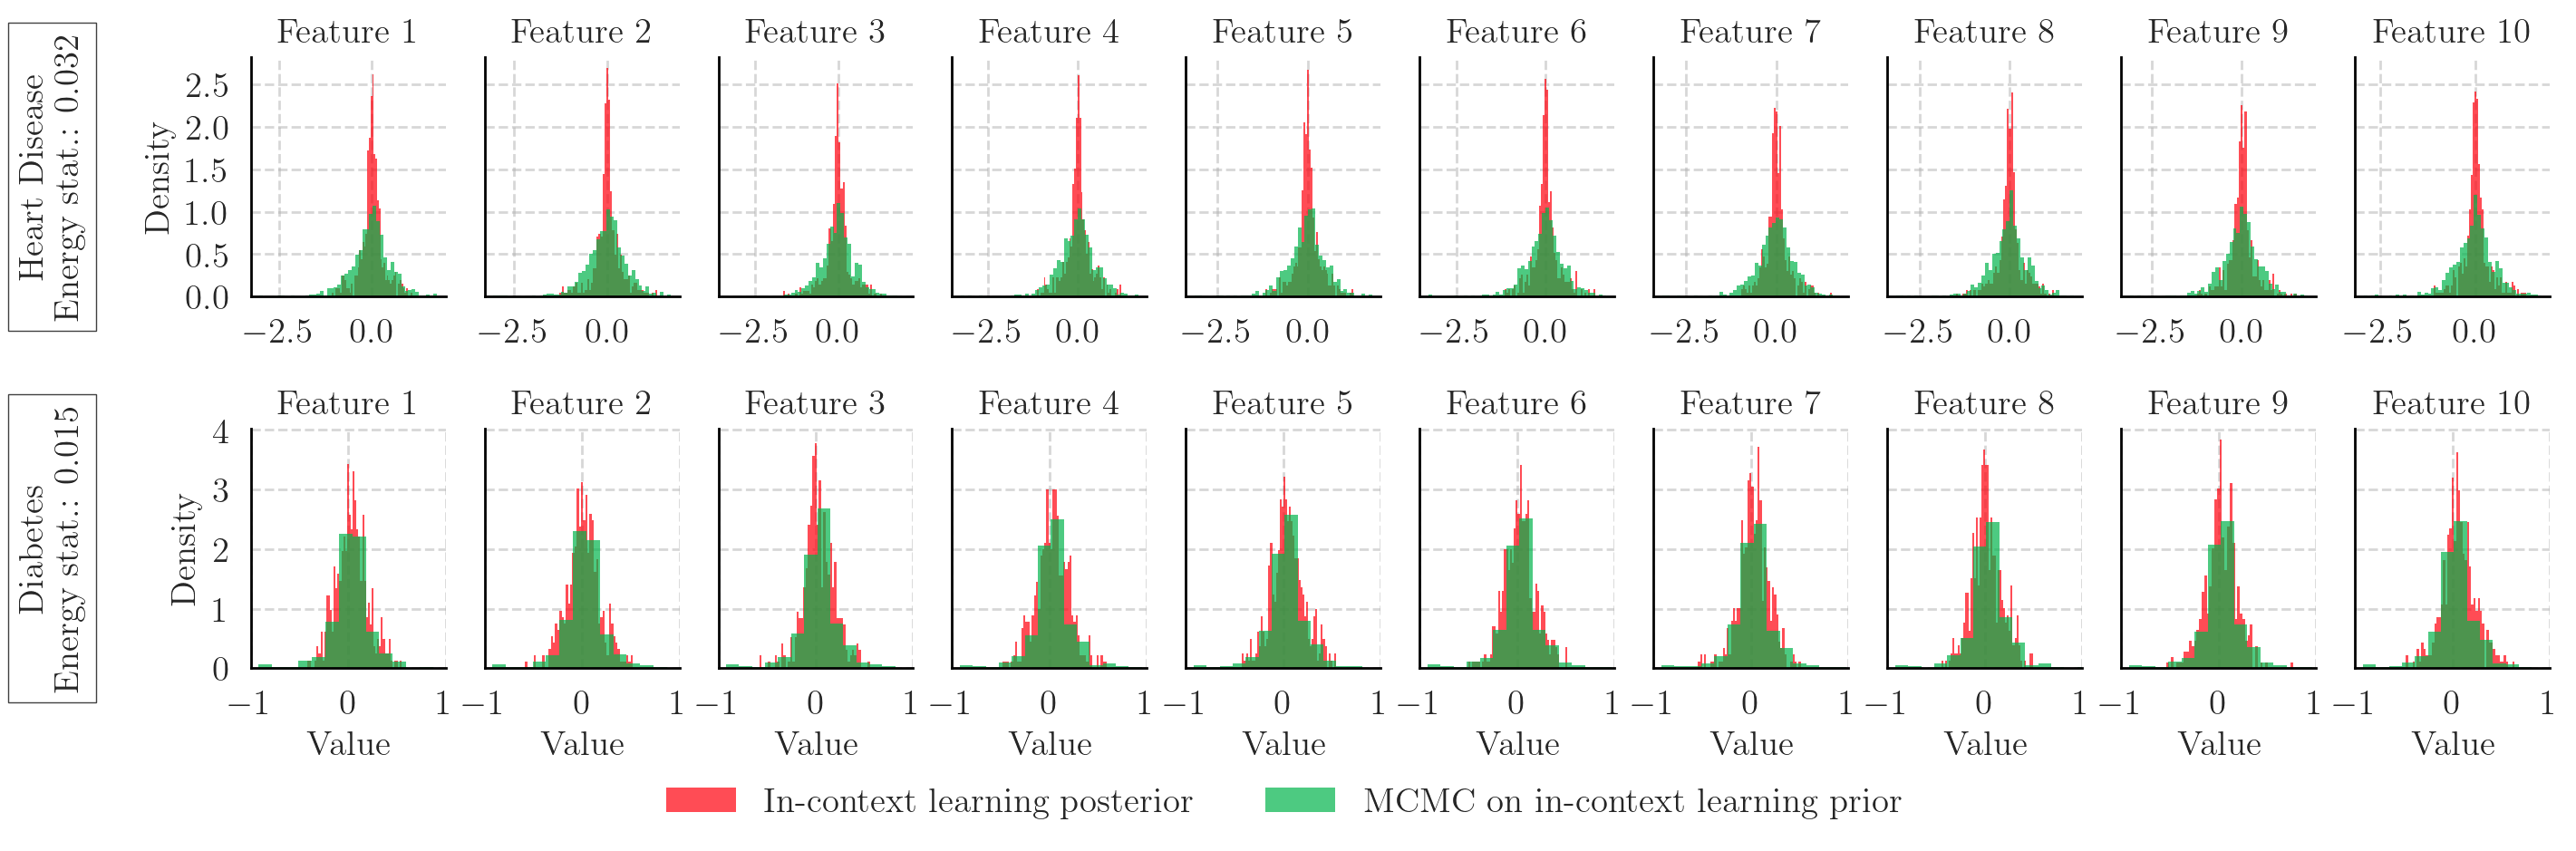

In [17]:
plt.close()

split_to_plot = 0

alpha = 0.7

hist_config = dict(
    alpha = alpha,
    bins=50,
    edgecolor = "black",
    linewidth = 0.0,
    stat = "density",
)


dataset_order = [
    "heart_disease",
    #"hypothyroid",
    "diabetes",
    #"breast_cancer",
    #"california_housing",
    #"wine_quality",
]

dataset_nice_names = {
    "breast_cancer": "Breast Cancer",
    "california_housing": "California Housing",
    "wine_quality": "Wine Quality",
    "heart_disease": "Heart Disease",
    "diabetes": "Diabetes",
    "hypothyroid": "Hypothyroid",
}

palette = {
    "internal_model": "xkcd:bright red",
    "mc_prior":  "xkcd:shamrock",
}

fontsize = 14

with graph_theme():

    ncols = 10
    nrows = len(dataset_order)
    fig_width = 2*linewidth
    fig_height = 0.6*0.8*2*1.1*linewidth/1.618

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(fig_width, fig_height),
        sharey="row",
    )

    for d_i, dataset in enumerate(dataset_order):
        for split_number, (single_chain, single_approximated_posterior) in enumerate(
            zip(
                chains[dataset], approximated_posteriors[dataset]
            )
        ):
            
            if split_number != split_to_plot:
                continue
            
            if DATASET_MODEL_TYPES[dataset] == "regression":
                single_chain = single_chain[:, :, 1:] # removing the y noise

            n_features = single_chain.shape[-1] - 1

            flat_single_chain = single_chain.reshape(-1, single_chain.shape[-1])

            for feature in range(n_features):

                ax = axes[d_i, feature]

                sns.histplot(
                    cut_end_points(single_approximated_posterior[:, feature+1], 0, 100),
                    color=palette["internal_model"],
                    ax=ax,
                    **hist_config,
                )

                ax = sns.histplot(
                    cut_end_points(single_chain[:, feature+1, :].ravel(), 0, 100),
                    color=palette["mc_prior"],
                    ax=ax,
                    **hist_config,
                )

                locator = mpl_ticker.MaxNLocator(
                    nbins=4, steps=[1, 2, 4, 5], min_n_ticks=4
                )
                ax.yaxis.set_major_locator(locator)

                ax.set_title(f"Feature {feature+1}", fontsize=fontsize)
                
                ax.tick_params(axis='both', which='major', labelsize=fontsize)

                if feature == 0:
                    ax.set_ylabel("Density", fontsize=fontsize)
                else:
                    plt.setp(ax.get_yticklabels(), visible=False)
                
                if d_i == nrows - 1:
                    ax.set_xlabel("Value", fontsize=fontsize)
                else:
                    ax.set_xlabel("") 

                if dataset == "diabetes":
                    ax.set_xlim(-1, 1)


                if feature == 0:
                    trans = mpl_transforms.blended_transform_factory(
                        fig.transFigure, ax.transAxes
                    )
                    fig.text(
                        0.01, 0.5,
                        f"{dataset_nice_names[dataset]}"
                        + f"\nEnergy stat.: {difference_test_values[dataset][0][0]:.2g}",
                        horizontalalignment='left',
                        verticalalignment='center',
                        transform=trans,
                        fontsize=fontsize,
                        rotation=90,
                        multialignment="center",
                        bbox=dict(
                            facecolor='white', 
                            alpha=0.75, 
                            edgecolor='black',
                            linewidth=0.5
                        ),
                    )

                if n_features < ncols:
                    if feature == n_features - 1:
                        for unused_ax in axes[d_i, feature:]:
                            unused_ax.remove()


    fig.legend(
        handles=[
            mpatches.Patch(
                facecolor=palette["internal_model"], alpha=alpha, 
                linewidth=0.0, edgecolor="black",
                label="In-context learning posterior"
            ),
            mpatches.Patch(
                facecolor=palette["mc_prior"], alpha=alpha, 
                linewidth=0.0, edgecolor="black",
                label="MCMC on in-context learning prior"
            ),
        ],
        loc="center",
        ncol=2,
        fontsize=fontsize,
        bbox_to_anchor=(0.5, 0.04),
        frameon=False,
        )

    fig.subplots_adjust(
        hspace=0.55, wspace=0.2,
        left=0.1, right=0.99,
        top=0.925, bottom=0.2
    )
    
    fig.savefig(
        Path(
            SAVE_PATH, 
            f"mc_on_prior_vs_posterior_split_{split_to_plot+1}_grid_low_posterior_error.pdf"
        ),
    )
    fig.savefig(
        Path(
            SAVE_PATH, 
            f"mc_on_prior_vs_posterior_split_{split_to_plot+1}_grid_low_posterior_error.svg"
        ),
    )
    fig.savefig(
        Path(
            SAVE_PATH, 
            f"mc_on_prior_vs_posterior_split_{split_to_plot+1}_grid_low_posterior_error.png"
        ),
        dpi=300,
    )

    plt.show()